**Chapter 07**  
Moving Beyond Linearity

# 1 Polynomial Regression
Replacing the standard linear model with a polynomial regression:
$$
y_i=\beta_0+\beta_1x_i+\beta_2x_i^2+\ldots+\beta_dx_i^d+\epsilon_i
$$
where $\epsilon_i$ is the error term.

Suppose we have computed the fit at a particular value, $x_0$:
$$
\hat{f}(x_0)=\hat{\beta_0}+\hat{\beta_1}x_0^1+\ldots+\hat{\beta_d}x_0^d
$$
What is the variance of the fit, i.e. $Var \hat{f}(x_0)$? Least square returns variance estimates for each of the fitted coefficients $\hat{\beta_j}$, as well as the covariances between pairs of the coefficient estimates. If $\hat{C}$ is the $(d+1)\times (d+1)$ covariance matrix of the $\hat{\beta_j}$, and if $\ell_0^T=(1,x_0,x_0^2,\ldots,x_0^d)$, then $Var[\hat{f}(x_0)]=\ell_0^T\hat{C}\ell_0$

# 2 Step Functions
Here we break the range of $X$ into *bins*, and fit a individual constant in each bin. In more detail, we add cutpoints $c_1,c_2,\ldots,c_k$ in the range of $X$, and then construct $K+1$ new variables
$$
\begin{cases}
C_0(X) = I(X<c_1) \\
C_1(X) = I(c_1 \le X<c_2)\\
\vdots\\
C_{K-1}(X)=I(c_{K-1}\le X < c_K) \\
C_K(X) = I(c_k \le X)
\end{cases}
$$
where $I()$ is an indicator function that returns a 1 if the condition is true, and returns a 0 otherwise.

We fit the least squares to fit a linear model using $C_1(X),C_2(X),\ldots,C_k(X)$ as preditors:
$$
y_i=\beta_0+\beta_1C_1(x_i)+\beta_2C_2(x_i)+\ldots+\beta_kC_K(x_i)+\epsilon_i
$$

# 3 Basis Functions
Instead of fitting a linear model in $X$, we fit the model
$$
y_i=\beta_0+\beta_1b_1(x_i)+\beta_2b_2(x_i)+\ldots+\ldots+\beta_kb_k(x_i)+\epsilon_i
$$

# 4 Regression Splines
## 4.1 Piecewise Polynomials
The approach involves fitting separate low-degree polynomials over different regions of $X$. For example, a piecewise cubic polynomial works by fit a cubic regression model of the following form:
$$
y_i=\beta_0+\beta_1x_i+\beta_2x_i^2+\beta_3x_i^3+\epsilon
$$
where the coefficients $\beta_0,\beta_1,\beta_2,\beta_3$ differ in different parts of the range of $X$.

## 4.2 Constraints and Splines
We fit a piecewise polynomial under the constraint that the fitted curve must be not only **continuous** but also **smooth**. Generally speaking, a cubic spline with $K$ knots uses a total of $4+K$ degrees of freedom.

## 4.3 The Spline Basis Representation
A cubic spline with $K$ knots can be models as 
$$
y_i=\beta_0+\beta_1b_1(x_i)+\beta_2b_2(x_i)+\ldots+\beta_{k+3}b_{k+3}(x_i)+\epsilon_i
$$
for an appropriate choice of basis functions $b_1,b_2,\ldots,b_{k+3}$. The model can then be fit using least squares.

The most direct way to the represent a cubic spline using above formula is to start off with a basis for a cubic polynomial-namly, $x,x^2,x^3$-and then add one *truncated power basis* function per knot. A truncated power basis function is defined as
$$
h(x,\xi)=(x-\xi)_+^3 =
\begin{cases}
(x-\xi)^3 & if x>\xi \\
0 & otherwise \\
\end{cases}
$$
where $\xi$ is the knot. In order to fit a cubic spline to a data set with $K$ knots, we perform least squares regression with an intercept and $3+K$ predictors, of the form $X,X^2,X^3,h(X,\xi_1),h(X,\xi_2),\ldots,h(X,\xi_k)$, where $\xi_1,\ldots,\xi_k$ are the knots. The amounts to estimating a total of $K+4$ regression coefficients.

### Implementation

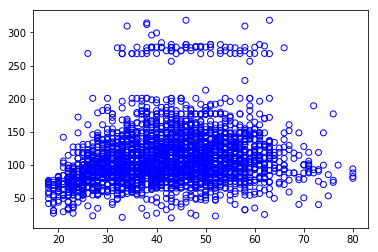

In [19]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
# load the wages
Wages = pd.read_csv('Wage.csv',index_col=0)
ages = Wages['age'].values
wages = Wages['wage'].values
plt.scatter(ages, wages, marker='o',edgecolor='b', color='none')
plt.show()

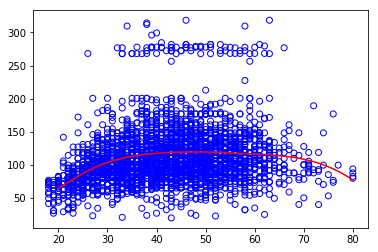

In [28]:
ages_quadratic = np.power(ages,2)
ages_cublic = np.power(ages, 3)
# knots 
knots = [25, 40, 60]
def h(x, knot):
    res = x - knot
    res[res<=0]=0
    return np.power(res, 3)
age_knot_1, age_knot_2, age_knot_3 = h(ages, knots[0]),h(ages, knots[1]),h(ages, knots[2])
beta_0_coefficients = [1]*len(ages)
X = np.array([beta_0_coefficients,ages,ages_quadratic,ages_cublic,age_knot_1,age_knot_2,age_knot_3]).T
y = wages.T
beta = inv(X.T.dot(X)).dot(X.T).dot(y) 
def predict(x):
    result = beta[0]
    result += x * beta[1]
    result += x**2*beta[2]
    result += x**3*beta[3]
    if x > knots[0]:
        result += (x-knots[0])**3*beta[4]
    if x > knots[1]:
        result += (x-knots[1])**3*beta[5]
    if x > knots[2]:
        result += (x-knots[2])**3*beta[6]
    return result

x = np.linspace(20,80, 100)
y = []
for _ in x:
    y.append(predict(_))
plt.scatter(ages, wages, marker='o',edgecolor='b', color='none')
plt.plot(x,y,'r')
plt.show()

## 4.4 Choosing the number and locations of the Knots
One option is to place more knots in the places where we recongine the function might vary most rapidly, and to place fewer knots where it seems more stable.
Most of all, the most objective approach is to use cross-validation.

# 5 Smoothing Splines
## 5.1 An overview of Smoothing Splines
A natural approach is to find the function $g$ that minimizes
$$
\sum_{i=1}^{n}(y_i-g(x_i))^2 +\lambda \int g''(t)^2dt
$$

where $\lambda$ is a nonnegative *turning parameters*. The first derivatives $g'(t)$ indicates the slope of a function at $t$, and the second derivatives corresponds the amount by which the slope is changing. Hence, broadly speaking, the second derivative of a function is measure of its *roughness*.

# 6 Local Regression
A Approach for fitting flexible non-linear functions, which involves computing the fit at a target point $x_0$ using only the nearby training observations.  

**Algorithm**  
Local regression at $X=x_0$
 
+ Gather the fraction $s=k/n$ of the training point whose $x_i$ are closest to $x_0$
+ Assign a weight $K_{i0}=K(x_i,x_0)$ to each point in his neighborhood, so that the point furthest from $x_0$ has weight zero, and the closest has the highest weight. All but these $k$ nearest neighbors get weight zero.
+ Fit a *weighted least squares regression* of the $y_i$ on the $x_i$ using the aforementioned weighted, by finding $\hat{\beta_0}$ and $\hat{\beta_1}$ that minimize 
$$
\sum_{i=1}^nK_{i0}(y_i-\beta_0-\beta_1x_i)^2
$$

+ The fitted value at $x_0$ is given by $\hat{f}(x_0)=\hat{\beta_0}+\hat{\beta_1}x_0$

# 7 Generalized Additive Models
GAMs provide a general framework for extending a standard linear model by allowing non-linear functions of each of a variables, while maintaining *additivity*. 
## 7.1 GAMs for Regression Problems
The model as 
$$
y_i = \beta_0+\sum_{j=1}^{p}f_j(x_{ij})+\epsilon_i
$$

## 7.2 GAMs for Classification Problems
GAMs can also be used in situations where Y is qualitative.
$$
log\big(\frac{p(X)}{1-p(X)}\big)=\beta_0+f_1(X_1)+f_2(X_2)+\ldots+f_p(X_p)
$$